# Estudio del modelo directo de un tomógrafo optoacústico basado en j-Wave

- Papers
    * [Descripción de la configuracion experimental](https://arxiv.org/pdf/2404.10239)
    * [Descripción del detector](http://elektron.fi.uba.ar/index.php/elektron/article/view/186)
    * [Un estudio anterior nuestro sobre el modelo directo en TOA](https://arxiv.org/pdf/2109.14028)
    * [sobre DAS](https://ieeexplore.ieee.org/document/8930614)
    * [sobre LBP](https://arxiv.org/abs/2210.08099)

- Repositorios
    * 

## 1. Tomografía Optoacústica

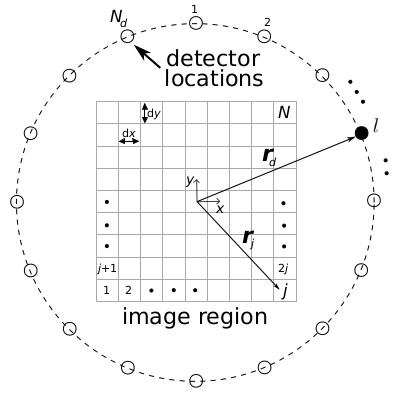

### 1.1 Generación de la matriz directa o modelo matricial

In [1]:
from dataclasses import dataclass
import numpy as np

@dataclass
class DatasetConfig:    
           
    # Simulation parameters
    arco = 360      # arc of the circunferencewhere the detectors are placed
    Rs = 44e-3      # radius of the circunference where the detectors are placed [m]
    Ns = 360//10    # number of detectors
    dx = 115e-6     # pixel size  in the x direction [m]
    nx = 128        # number of pixels in the x direction for a 2-D image region
    vs = 1490       # speed of sound [m/s]
    to = 21.5e-6    # initial time [s]
    T = 25e-6       # size of the time windows [s].
    tf = to + T     # final time [s].
    Nt = 1024       # number of time samples
    Nd = nx*8       # number of pixels of the j-wave SPATIAL GRID
    thresh = 0      # threshold the matrix to remove small entries and make it more sparse 10**(-thresh)
    nhie = 0        # Non homogeneous illumnation effect? if nihe == 0 --> is disable
    astr = False    # Apply sensor time response? True or False
    appfil = False  # Apply filter? True or False
    saveAj = False  # save generated matrix for the future?
    loadAj = False  # load a previouly saved matriz?
    filenameAj = 'Aj.npz'

config = DatasetConfig()

In [2]:
from utils.jbuildmatrix import createJForwMatdotdet

Aj = createJForwMatdotdet(config.Ns,config.Nt,config.dx,config.nx,config.Rs,config.vs,config.to,config.tf,config.nhie,config.astr,config.appfil,config.saveAj)
Aj = Aj.astype(np.float32)    

Running j-wave simulation...
done!
Creating matrix...


100%|████████████████████████████████████| 16384/16384 [01:39<00:00, 165.43it/s]


done!
Time to create the matrix [minutes] 2.078194131183348


### 1.2 Carga de la imagen verdadera

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 0, '$n_x$'),
 Text(0, 0.5, '$n_x$'))

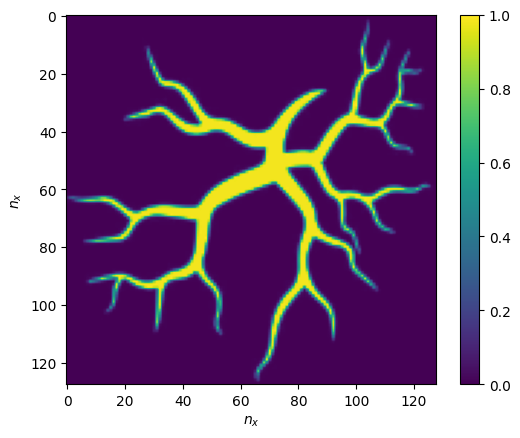

In [3]:
import matplotlib.pyplot as plt
from utils.procutils import loadingimage, numpynorm

Xtr = loadingimage('venas3x128',True)
Xtr = numpynorm(Xtr,1,0)

plt.figure(),plt.imshow(Xtr,cmap="viridis"),plt.colorbar(),plt.xlabel('$n_x$'),plt.ylabel('$n_x$')

### 1.3 Generación del Sinograma sintético

(<Figure size 1500x1500 with 1 Axes>,
 Text(0.5, 0, '$N_t$'),
 Text(0, 0.5, '$N_s$'))

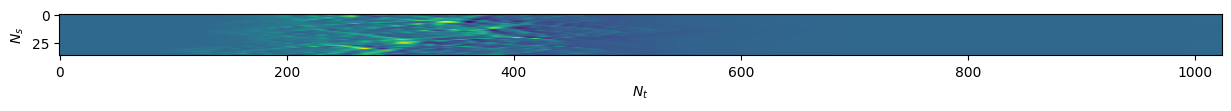

In [4]:
from utils.oatutils import calcsinogram

Str = calcsinogram(Aj,Xtr,config.Ns,config.Nt)

plt.figure(figsize=(15,15)),plt.imshow(Str,cmap="viridis"),plt.xlabel('$N_t$'),plt.ylabel('$N_s$')

##### Otra forma de graficar los sinogramas cuando $N_s \ll N_t$ 

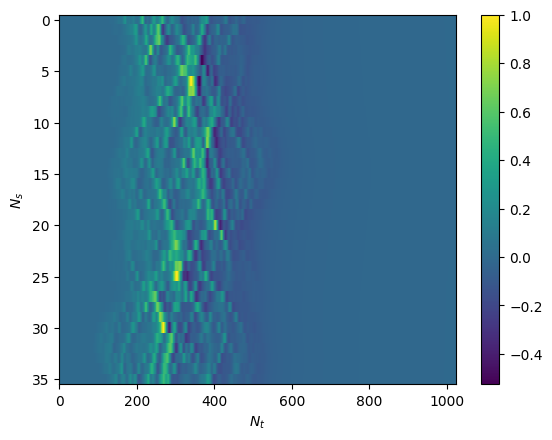

In [5]:
from utils.oatutils import plotsquaresinogram

plotsquaresinogram(Str)

#### Cómo se ve la señal de un detector, por ejemplo, para $N_s = 18$

(Text(0, 0.5, 'Amplitud (a.u.)'), None)

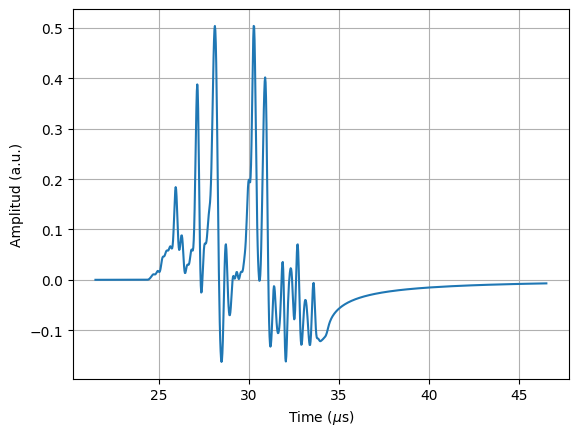

In [6]:
ejet = np.linspace(config.to,config.tf,config.Nt).astype(np.float32) 
numdet = 18
plt.plot(ejet*1e6,Str[numdet,:])
plt.xlabel('Time ($\mu$s)'); plt.ylabel('Amplitud (a.u.)'),plt.grid()

### 1.4 Agregado de ruido

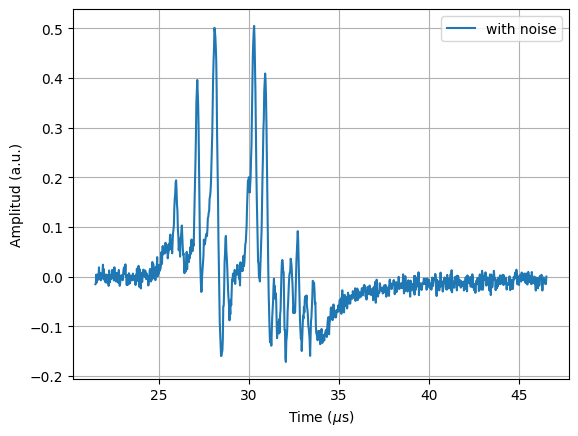

In [7]:
from utils.oatutils import addwhitenoise

Strn =  addwhitenoise(2e-2,Str)

plt.plot(ejet*1e6,Strn[numdet,:],label='with noise')
plt.xlabel('Time ($\mu$s)'); plt.ylabel('Amplitud (a.u.)'),plt.grid()
plt.legend()

### 1.5 Reconstrucción de la imagen usando Delay & Sum (DAS)

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 0, '$n_x$'),
 Text(0, 0.5, '$n_x$'))

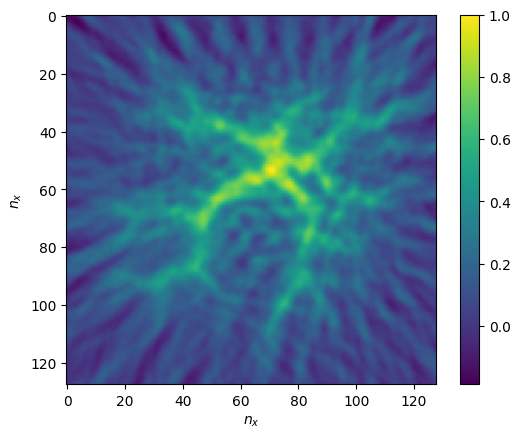

In [8]:
from utils.OAT24 import applyDAS

X1 = applyDAS(config.Ns,config.Nt,config.dx,config.nx,config.Rs,config.arco,config.vs,config.to,config.tf,Strn)

plt.figure(),plt.imshow(X1,cmap="viridis"),plt.colorbar(),plt.xlabel('$n_x$'),plt.ylabel('$n_x$')

### 1.6 Reconstrucción de la imagen usando Lineal Back-Projection (LBP)
OJO: hay un poco de trampa ya estamos usando la misma matris con la que creamos el sinogrma

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 0, '$n_x$'),
 Text(0, 0.5, '$n_x$'))

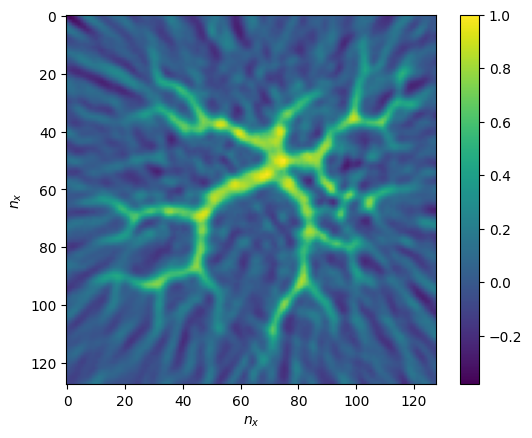

In [9]:
from utils.oatutils import calcLBP

X2 = calcLBP(Aj,Strn)

plt.figure(),plt.imshow(X2,cmap="viridis"),plt.colorbar(),plt.xlabel('$n_x$'),plt.ylabel('$n_x$')

#### Comparando las reconstrucciones

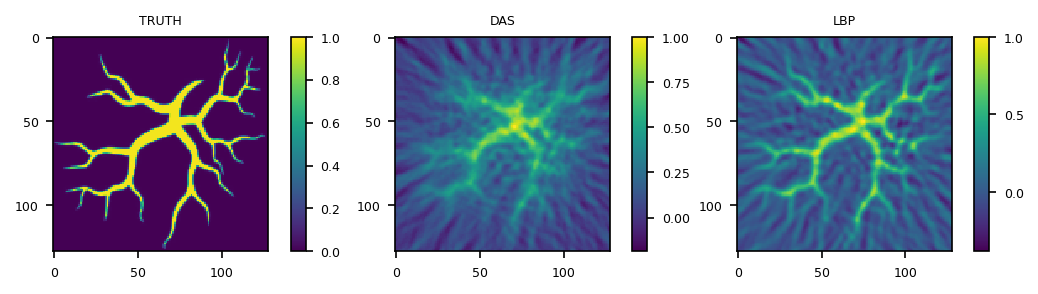

In [10]:
from utils.procutils import plotimage

Xcomp = np.zeros((3,config.nx,config.nx),dtype=np.float32)
Xcomp[0,:,:]=Xtr; Xcomp[1,:,:]=X1; Xcomp[2,:,:]=X2;
plotimage(Xcomp,'',3,(7,7),('TRUTH','DAS','LBP'),6,1.2)

### Cuantificando las diferencias

In [11]:
from utils.procutils import FoM

def calcFoM(Y,Xdas,Xlbp):
    # Measuring the quality of the reconstruction 
    H,W = Y.shape
    print('Calculating metrics...')
    SSIM = np.zeros((2,)).astype(np.float32)
    PC = np.zeros((2,)).astype(np.float32)
    RMSE = np.zeros((2,)).astype(np.float32)
    PSNR = np.zeros((2,)).astype(np.float32)
    f1,f2,f3,f4=FoM(Y,Xdas)
    SSIM[0]=f1; PC[0]=f2; RMSE[0]=f3; PSNR[0]=f4
    f1,f2,f3,f4=FoM(Y,Xlbp)
    SSIM[1]=f1; PC[1]=f2; RMSE[1]=f3; PSNR[1]=f4

    print('\n')
    print('############################################################### \n')
    print('Metrics results DAS: \n', 'SSIM: ',round(np.mean(SSIM[0]),3), ' PC: ', round(np.mean(PC[0]),3), ' RMSE: ', round(np.mean(RMSE[0]),3), ' PSNR: ', round(np.mean(PSNR[0]),3))
    print('\n')
    print('Metrics results LBP: \n', 'SSIM: ',round(np.mean(SSIM[1]),3), ' PC: ', round(np.mean(PC[1]),3),' RMSE: ', round(np.mean(RMSE[1]),3), ' PSNR: ', round(np.mean(PSNR[1]),3))
    print('\n')
    print('############################################################### \n')
    

    return SSIM,PC,RMSE,PSNR

SSIM,PC,RMSE,PSNR = calcFoM(Xtr.astype(np.float32),X1.astype(np.float32),X2.astype(np.float32))

Calculating metrics...


############################################################### 

Metrics results DAS: 
 SSIM:  0.118  PC:  0.682  RMSE:  0.221  PSNR:  13.112


Metrics results LBP: 
 SSIM:  0.272  PC:  0.842  RMSE:  0.156  PSNR:  16.132


############################################################### 



### 1.7 Otro ejemplo con una imagen más sencilla pero agregando la respuesta del detector

In [13]:
# Teniendo en cuenta la respuesta del detector
Aj2 = createJForwMatdotdet(config.Ns,config.Nt,config.dx,config.nx,config.Rs,config.vs,config.to,config.tf,config.nhie,True,config.appfil,config.saveAj)
Aj2 = Aj2.astype(np.float32)   

Running j-wave simulation...
done!
Creating matrix...


100%|████████████████████████████████████| 16384/16384 [01:40<00:00, 163.14it/s]


done!
Applying detector impulse response to j-wave matrix..
Time to create the matrix [minutes] 3.446523052750005


In [14]:
# Aplicando un filtro pasabanda
Aj3 = createJForwMatdotdet(config.Ns,config.Nt,config.dx,config.nx,config.Rs,config.vs,config.to,config.tf,config.nhie,config.astr,True,config.saveAj)
Aj3 = Aj3.astype(np.float32)  

Running j-wave simulation...
done!
Creating matrix...


100%|████████████████████████████████████| 16384/16384 [01:38<00:00, 166.66it/s]


done!
Applying filter to j-wave sinogram...
Time to create the matrix [minutes] 3.434868015216671


In [15]:
Xtr2 = loadingimage('imgmed2',False) 

Str21 = calcsinogram(Aj,Xtr2,config.Ns,config.Nt)
Str22 = calcsinogram(Aj2,Xtr2,config.Ns,config.Nt)
Str23 = calcsinogram(Aj3,Xtr2,config.Ns,config.Nt)

Strn21 = addwhitenoise(2e-2,Str21)
Strn22 = addwhitenoise(2e-2,Str22)
Strn23 = addwhitenoise(2e-2,Str23)
X21 = applyDAS(config.Ns,config.Nt,config.dx,config.nx,config.Rs,config.arco,config.vs,config.to,config.tf,Strn21)
X22 = applyDAS(config.Ns,config.Nt,config.dx,config.nx,config.Rs,config.arco,config.vs,config.to,config.tf,Strn22)
X23 = applyDAS(config.Ns,config.Nt,config.dx,config.nx,config.Rs,config.arco,config.vs,config.to,config.tf,Strn23)

Text(0.5, 1.0, 'Sinograma teniendo en cuenta respuesta sensor')

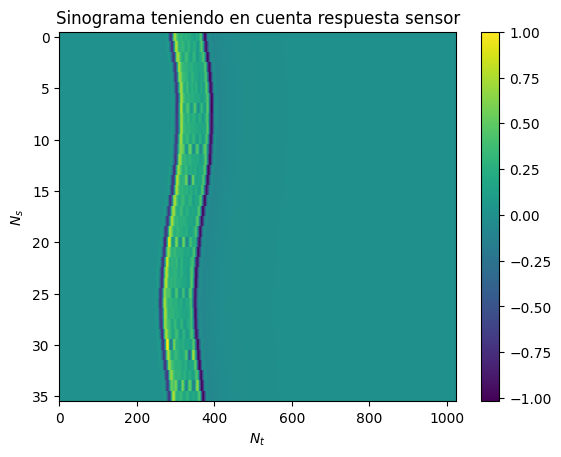

In [16]:
plt.imshow(Str22,cmap="viridis",interpolation='nearest',aspect='auto')
plt.colorbar(),plt.xlabel('$N_t$'),plt.ylabel('$N_s$')
plt.title('Sinograma teniendo en cuenta respuesta sensor')

Text(0.5, 1.0, 'Sinograma filtrado')

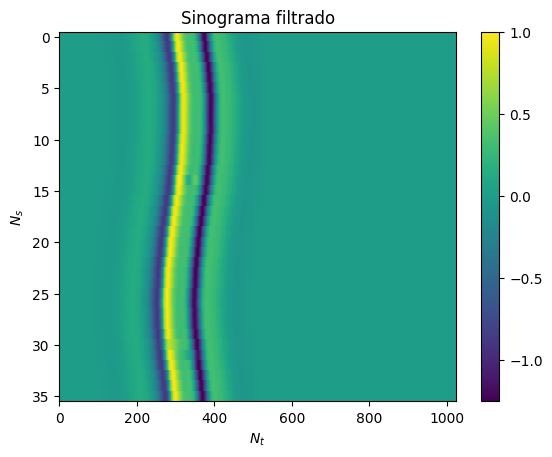

In [37]:
plt.imshow(Str23,cmap="viridis",interpolation='nearest',aspect='auto')
plt.colorbar(),plt.xlabel('$N_t$'),plt.ylabel('$N_s$')
plt.title('Sinograma filtrado')

(25.0, 35.0)

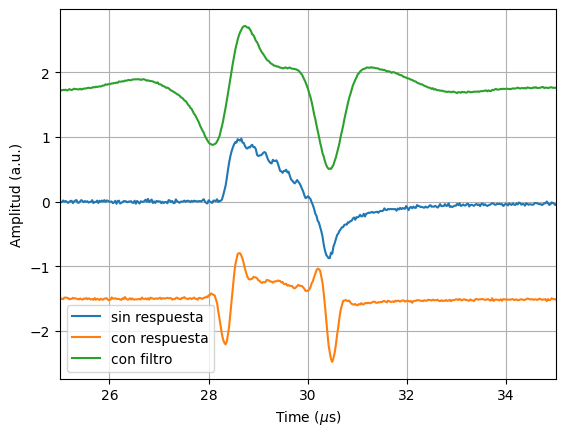

In [36]:
plt.plot(ejet*1e6,Strn21[numdet,:],label='sin respuesta')
plt.plot(ejet*1e6,Strn22[numdet,:]-1.5,label='con respuesta')
plt.plot(ejet*1e6,Strn23[numdet,:]+1.75,label='con filtro')
plt.xlabel('Time ($\mu$s)'); plt.ylabel('Amplitud (a.u.)'),plt.grid()
plt.legend()
plt.xlim([25,35])

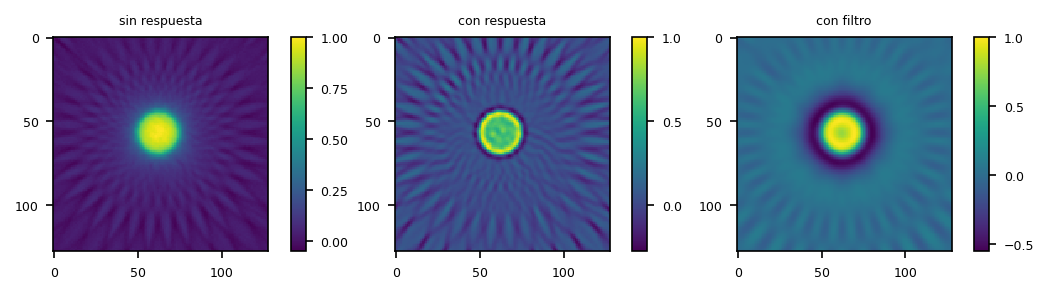

In [18]:
Ys2 = np.zeros((3,config.nx,config.nx),dtype='float32')
Ys2[0,:,:] = X21; Ys2[1,:,:] = X22; Ys2[2,:,:] = X23; 
plotimage(Ys2,'',3,(7,7),('sin respuesta','con respuesta','con filtro'),6,1.2)

In [19]:
from utils.procutils import calcfft

ejef,s18_1 = calcfft(ejet,Strn21[numdet,:])
ejef,s18_2 = calcfft(ejet,Strn22[numdet,:])
ejef,s18_3 = calcfft(ejet,Strn23[numdet,:])

(None, <matplotlib.legend.Legend at 0x7f82b01b78e0>)

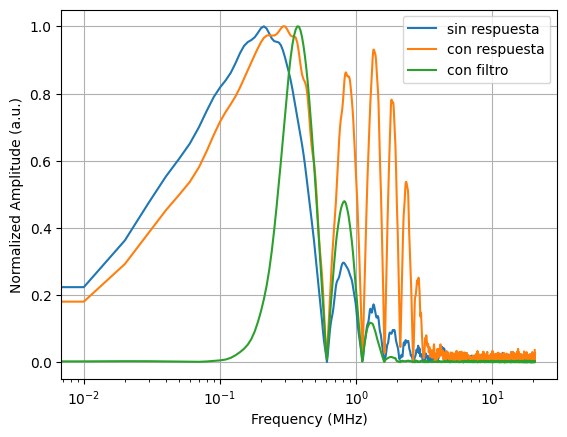

In [20]:
plt.semilogx(ejef*1e-6,s18_1,label='sin respuesta')
plt.semilogx(ejef*1e-6,s18_2,label='con respuesta')
plt.semilogx(ejef*1e-6,s18_3,label='con filtro')
plt.xlabel('Frequency (MHz)'); plt.ylabel('Normalized Amplitude (a.u.)')
plt.grid(), plt.legend()

## 2. Algunas mediciones realizadas con nuestro setup

### 2.1 Cargando los datos experimentales

In [21]:
from utils.oatutils import loaddata, resamptime

def calcFoMvm(IT,IM):
    
    SSIM,PC,RMSE,PSNR = FoM(IT,IM)
    
    print('\n')
    print('#################################################################################### \n')
    print('Valores de las figuras de mérito entre imagen verdadera y reconstrucción DAS \n')
    print('SSIM: ',round(SSIM,3), ' PC: ', round(PC,3), ' RMSE: ', round(RMSE,3), ' PSNR: ', round(PSNR,3))
    print('\n')
    print('################################################################################### \n')  

#### Disco de 3 mm diámetro

In [22]:
filename = 'data/med12dic23_2.npz'

sample1, vs1, Rs, t, S = loaddata(filename)
t1, S1 = resamptime(t,S,config.Nt)
S1 = S1/np.max(S1.ravel())
Ymed1 = applyDAS(config.Ns,config.Nt,config.dx,config.nx,config.Rs,config.arco,vs1,t1[0],t1[-1],S1)

I1 = loadingimage('imgmed2',False) 

(<matplotlib.colorbar.Colorbar at 0x7f82b01a1eb0>,
 Text(0.5, 0, '$N_t$'),
 Text(0, 0.5, '$N_s$'))

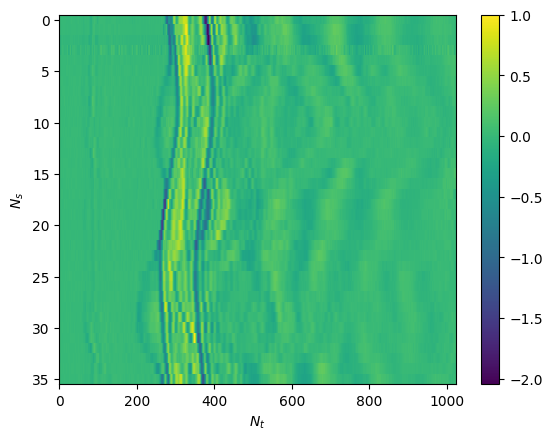

In [23]:
plt.imshow(S1,cmap="viridis",interpolation='nearest',aspect='auto')
plt.colorbar(),plt.xlabel('$N_t$'),plt.ylabel('$N_s$')

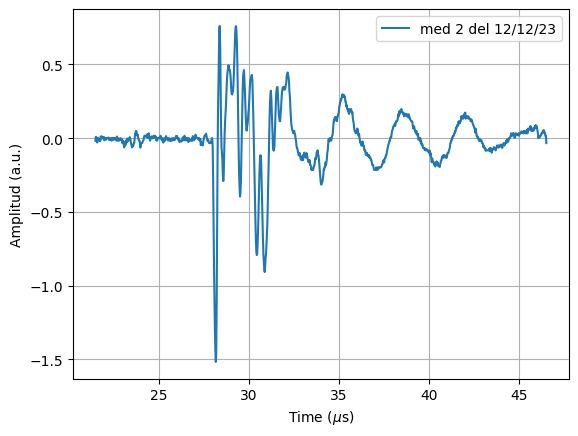

In [24]:
ejet1 = np.linspace(t1[0],t1[-1],config.Nt).astype(np.float32) 
numdet = 18
plt.plot(ejet1*1e6,S1[numdet,:],label='med 2 del 12/12/23')
plt.xlabel('Time ($\mu$s)'); plt.ylabel('Amplitud (a.u.)'),plt.grid()
plt.legend()

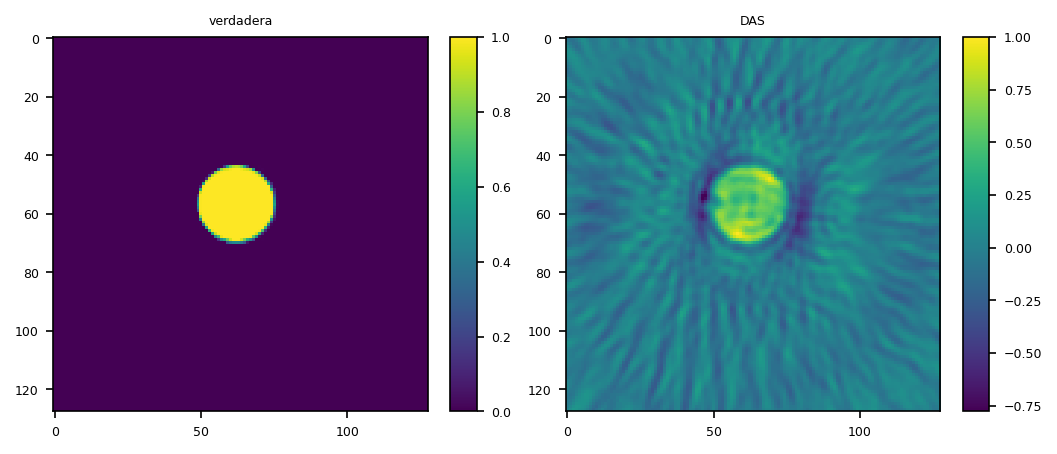

In [25]:
Y1 = np.zeros((2,config.nx,config.nx),dtype='float32')
Y1[0,:,:] = I1; Y1[1,:,:] = Ymed1; 
Ymed1=Ymed1.astype(np.float32)
plotimage(Y1,'',2,(7,7),('verdadera','DAS'),6,1.2)

In [26]:
calcFoMvm(I1,Ymed1)



#################################################################################### 

Valores de las figuras de mérito entre imagen verdadera y reconstrucción DAS 

SSIM:  0.044  PC:  0.698  RMSE:  0.137  PSNR:  17.283


################################################################################### 



### Disco de 4 mm + Anillo de 10 mm concéntricos 

In [28]:
filename = 'data/med12dic23_3.npz'

sample2, vs2, Rs, t, S = loaddata(filename)
t2, S2 = resamptime(t,S,config.Nt)
Ymed2 = applyDAS(config.Ns,config.Nt,config.dx,config.nx,config.Rs,config.arco,vs2,t2[0],t2[-1],S2)
Ymed2=Ymed2.astype(np.float32)
I2 = loadingimage('imgmed3',False) 

(<matplotlib.colorbar.Colorbar at 0x7f82b0116f10>,
 Text(0.5, 0, '$N_t$'),
 Text(0, 0.5, '$N_s$'))

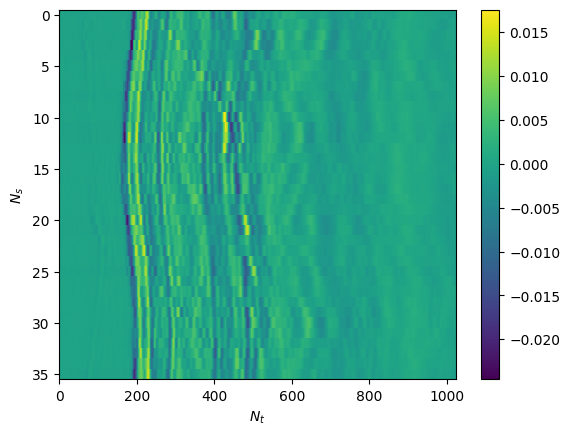

In [29]:
plt.imshow(S2,cmap="viridis",interpolation='nearest',aspect='auto')
plt.colorbar(),plt.xlabel('$N_t$'),plt.ylabel('$N_s$')

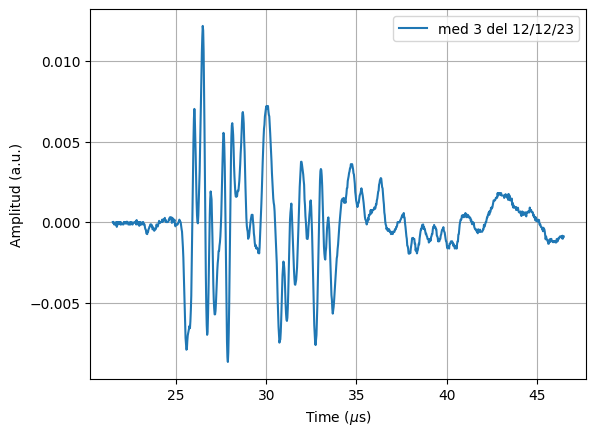

In [30]:
ejet2 = np.linspace(t2[0],t2[-1],config.Nt).astype(np.float32) 
numdet = 18
plt.plot(ejet2*1e6,S2[numdet,:],label='med 3 del 12/12/23')
plt.xlabel('Time ($\mu$s)'); plt.ylabel('Amplitud (a.u.)'),plt.grid()
plt.legend()

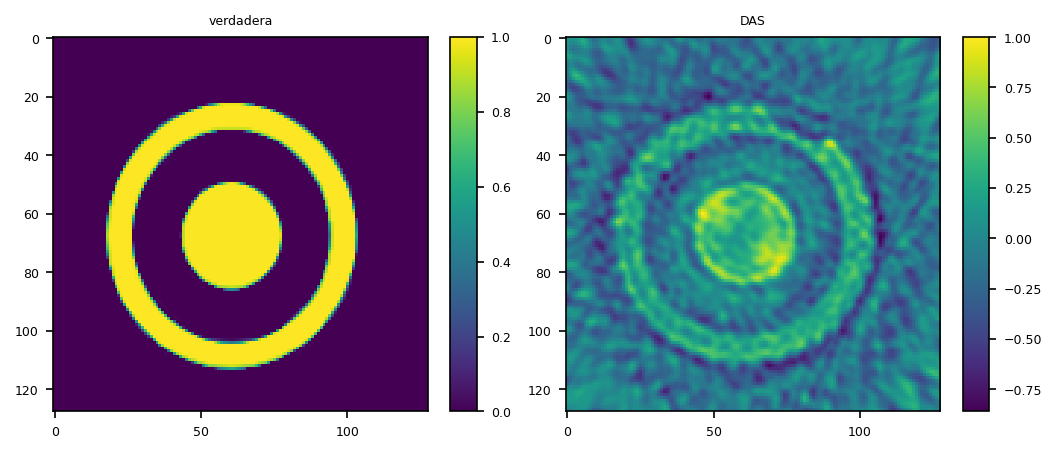

In [31]:
Y2 = np.zeros((2,config.nx,config.nx),dtype='float32')
Y2[0,:,:] = I2; Y2[1,:,:] = Ymed2; 
plotimage(Y2,'',2,(7,7),('verdadera','DAS'),6,1.2)

In [32]:
calcFoMvm(I2,Ymed2)



#################################################################################### 

Valores de las figuras de mérito entre imagen verdadera y reconstrucción DAS 

SSIM:  0.014  PC:  0.646  RMSE:  0.386  PSNR:  8.263


################################################################################### 



#### Comparando espectros medidos para $N_s = 18$

(None, <matplotlib.legend.Legend at 0x7f82684536d0>)

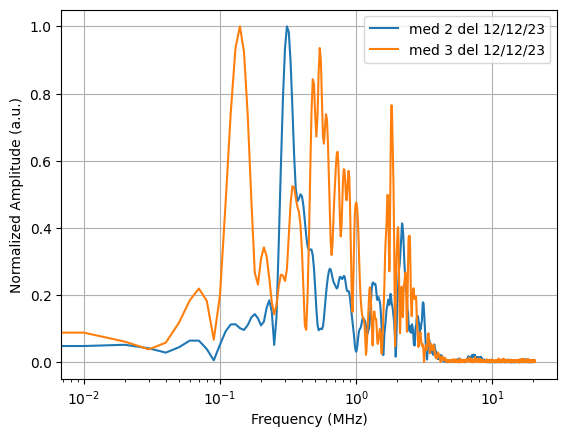

In [34]:
ejef2,s18_med3 = calcfft(t2,S2[numdet,:])
plt.semilogx(ejef1*1e-6,s18_med2,label='med 2 del 12/12/23')
plt.semilogx(ejef2*1e-6,s18_med3,label='med 3 del 12/12/23')
plt.xlabel('Frequency (MHz)'); plt.ylabel('Normalized Amplitude (a.u.)')
plt.grid(), plt.legend()

## 3. Tareas 

##### A Sobre OAT:
    A.1 Entender el setup experimental
    A.2 Entender cómo se crea la matriz A
    A.3 Entender el algortimo de reconstrucción DAS
    A.3 Comprender las limitaciones del modelo matricial

##### B. Mediciones
    B.1 Analizar las mediciones ya realizadas 
    B.2 Llevar a cabo más mediciones para ajustar el modelo matricial
    B.3 Relevar el ruido sin muestra para luego modelar el ruido coloreado usando VAE 
    B.4 Modelar que ruido blanco (SNR Max y Desvio) corresponde a la mediciones. Usar 1ra parte de los sinogramas.
    
    
##### C. ¿Qué ajustar en el modelo matricial?
    C.1 Inhomogeneidad de la iluminación
    C.2 Ruido (Por fuera de la martiz Aj)
    C.3 Respuesta temporal del sistema (Sensor y filtro)

##### D. ¿Cómo realizar el ajuste?
    D.1 Análisis temporal y espectral de la señales captadas por el detector
    D.2 Análisis cuantitativo de las imágenes reconstruidas con DAS
       
##### E. Escritura Trabajo para revista Elektron (fecha límite: 1 de novimienbre)

## 4. Fechas límites 

##### Ajuste modelo: 1 de octubre

#####  Escritura Trabajo para revista Elektron: 1 de novimienbre